CS456 Datamining Final Project
Group 2

The following is an analysis of steam games data provided fom Kaggle.
We will start by importing pandas and numpy. We will also create our main dataframe object.

In [3]:
#Import Statements
import pandas as pd
import numpy as np

#Create Dataframe from CSV
df = pd.read_csv("games.csv", engine="python", on_bad_lines="warn")

#Display first 5 rows and dataframe info
print(df.head(5))
print(df.info())


<ipython-input-3-d626a4d8779d>:6: ParserWarning: Skipping line 43287: unexpected end of data

  df = pd.read_csv("games.csv", engine="python", on_bad_lines="warn")


                         AppID          Name Release date  Estimated owners  \
20200         Galactic Bowling  Oct 21, 2008    0 - 20000                 0   
655370            Train Bandit  Oct 12, 2017    0 - 20000                 0   
1732930           Jolt Project  Nov 17, 2021    0 - 20000                 0   
1355720             Henosisâ¢  Jul 23, 2020    0 - 20000                 0   
1139950  Two Weeks in Painland   Feb 3, 2020    0 - 20000                 0   

         Peak CCU  Required age  Price  DiscountDLC count  \
20200           0         19.99      0                  0   
655370          0          0.99      0                  0   
1732930         0          4.99      0                  0   
1355720         0          5.99      0                  0   
1139950         0          0.00      0                  0   

                                            About the game  \
20200    Galactic Bowling is an exaggerated and stylize...   
655370   THE LAW!! Looks to be a s

We can see here the first 5 rows of the dataframe, and some useful info: datatypes, memory usage, ect. 
Next, we will check for duplicates and missing values:

In [4]:
#Print column names
print("Columns in this dataset:")
print(df.columns)

#Check for duplicates and missing values; start with app IDs if they exist
if "AppID" in df.columns:
    dup_count = df.duplicated(subset="AppID").sum()
    print(f"\nDuplicate AppID rows: {dup_count}")

#If no AppID column, check for fully duplicate rows
else:
    dup_count = df.duplicated().sum()
    print(f"\nDuplicate rows: {dup_count}")

#Show missing values per column 
print("\nTop missing values per column:")

#Make a different dataframe to summarize missing values
missing_summary = df.isna().sum().sort_values(ascending=False)

#Print the missing values dataframe head
print(missing_summary.head(20))


Columns in this dataset:
Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

Duplicate AppID rows: 220

Top missing values per column:
Score rank                  43254
Metacritic url              40637
Notes                       37426
Reviews                     37107
Website                     20924
Support url                 20631
Support email       

We observe that we have alot of columns in this steam games dataset. Our output says we have 1,126 duplicate rows by just appID alone. We made a temporary dataframe to show our top missing values per column. As you can see, ['Score rank'] is at the top of the list. Fortunately however, the following values are never missing in the dataframe: Price, Estimated owners, and Release date.

We will proceed by removing rows with duplicate appIDs from our main dataframe (not the temporary one for missing values):

In [5]:
#Print dataframe shape BEFORE removing duplicate rows
print("Shape before duplicate row removal:", df.shape)

#Drop duplicate rows based on AppID
df.drop_duplicates(subset="AppID", inplace=True)

#Reset the index after dropping duplicate rows
df.reset_index(drop=True, inplace=True)

#Print dataframe shape AFTER removing duplicate rows
print("Shape after duplicate row removal:", df.shape)


Shape before duplicate row removal: (43285, 39)
Shape after duplicate row removal: (43065, 39)


We can see after removing the rows with duplicate AppIDs that we have 110,326 rows and still 39 columns. This means we dropped 1,126 rows that had duplicate AppIDs. When you do the math, this is only about 1% of our total data, but still great for cleaning up! Next we will clean the 'Release Date' column.

In [6]:
#After doing some testing I found that the "Release date" column is incorrectly labeled and actually contains owner range data. Fixed it. 
#Rename the incorrectly-labeled release date column to owner range
df.rename(columns={"Release date": "Owner range"}, inplace=True)
print("Column renamed. 'Release year' removed.")
print(df.columns)


Column renamed. 'Release year' removed.
Index(['AppID', 'Name', 'Owner range', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')


More dataframe cleaning:

In [7]:
#Show missing values before cleaning
print("Missing values BEFORE cleaning:")
print(df.isna().sum().head(20))

#Fill missing numeric columns with 0 or the median
numeric_cols = [
    "Price", 
    "Reviews",
    "Positive", 
    "Negative", 
    "User score",
    "Average playtime forever",
    "Average playtime two weeks",
    "Median playtime forever",
    "Median playtime two weeks"
]

# Loop through numeric columns and fill missing values correctly
for col in numeric_cols:
    if col in df.columns:
        # Convert to numeric so median() won't fail
        df[col] = pd.to_numeric(df[col], errors="coerce")
        
        # Compute median
        median_val = df[col].median()
        
        # If the median is NaN (column entirely NaN), use 0
        if pd.isna(median_val):
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(median_val)

#Fill missing text fields with empty string
text_cols = [
    "Genres", "Tags", "About the game", "Developers",
    "Publishers", "Categories", "Supported languages",
    "Full audio languages"
]

#loop through text columns and fill the missing values
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("")

#Show first 20 columns' missing values after cleaning
print("\nMissing values AFTER cleaning:")
print(df.isna().sum().head(20))


Missing values BEFORE cleaning:
AppID                       1
Name                        0
Owner range                 0
Estimated owners            0
Peak CCU                    0
Required age                0
Price                       0
DiscountDLC count           0
About the game           1111
Supported languages         0
Full audio languages        0
Reviews                 36927
Header image                0
Website                 20820
Support url             20525
Support email            6488
Windows                     0
Mac                         0
Linux                       0
Metacritic score            0
dtype: int64


/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Missing values AFTER cleaning:
AppID                       1
Name                        0
Owner range                 0
Estimated owners            0
Peak CCU                    0
Required age                0
Price                       0
DiscountDLC count           0
About the game              0
Supported languages         0
Full audio languages        0
Reviews                     0
Header image                0
Website                 20820
Support url             20525
Support email            6488
Windows                     0
Mac                         0
Linux                       0
Metacritic score            0
dtype: int64


Alright, this helped us clean up and populate missing stuff. This also helped us confirm some data types, because this data set is kind of messy. Next we'll make some of the genre tags into Python LISTS instead of raw strings for our genres. We'll need it like this for making predictions regarding game genre.

In [8]:
#This was a pain to figure out lol
#Remove brackets and quotes
df["Genres"] = df["Genres"].fillna("").astype(str).str.replace(r"[\[\]']", "", regex=True)
df["Tags"]   = df["Tags"].fillna("").astype(str).str.replace(r"[\[\]']", "", regex=True)

#Split on commas to convert into lists
df["Genres"] = df["Genres"].str.split(",")
df["Tags"]   = df["Tags"].str.split(",")

#Strip whitespace and remove empty strings
df["Genres"] = df["Genres"].apply(lambda lst: [x.strip() for x in lst if x.strip() != ""])
df["Tags"]   = df["Tags"].apply(lambda lst: [x.strip() for x in lst if x.strip() != ""])

#Display first 5 rows of cleaned Genres and Tags columns
df[["Genres", "Tags"]].head(5)

Genres  \
0               [Casual, Indie, Sports]   
1                       [Action, Indie]   
2  [Action, Adventure, Indie, Strategy]   
3            [Adventure, Casual, Indie]   
4                    [Adventure, Indie]   

                                                Tags  
0                   [Indie, Casual, Sports, Bowling]  
1  [Indie, Action, Pixel Graphics, 2D, Retro, Arc...  
2                                                 []  
3  [2D Platformer, Atmospheric, Surreal, Mystery,...  
4  [Indie, Adventure, Nudity, Violent, Sexual Con...

Our genres and tags columns are now clean and should be good to go to analyze, train models, and make predictions on. The last things to clean are fixing a missing value in AppID and normalize the numeric columns. 

In [9]:
#Import Statements
from sklearn.preprocessing import MinMaxScaler

#Remove rows where AppID is missing
df = df[df["AppID"].notna()]
df.reset_index(drop=True, inplace=True)

print("Rows after dropping missing AppID:", df.shape)

#Normalize numeric columns. Helpful for later on when making predictions
numeric_to_normalize = [
    "Price",
    "Reviews",
    "Positive",
    "Negative",
    "User score",
    "Average playtime forever",
    "Average playtime two weeks",
    "Median playtime forever",
    "Median playtime two weeks"
]

#Keep only numeric columns that actually exist
numeric_to_normalize = [col for col in numeric_to_normalize if col in df.columns]

#Make the scaler object
scaler = MinMaxScaler()

#Normalize the numeric columns so we can make predictions later
df[numeric_to_normalize] = scaler.fit_transform(df[numeric_to_normalize])

#Print first 5 rows of the newly normalized numeric columns
print("Normalization complete.")
print(df[numeric_to_normalize].head())


Rows after dropping missing AppID: (43064, 39)
Normalization complete.
   Price  Reviews  Positive  Negative  User score  Average playtime forever  \
0    0.0      0.0  0.000004  0.000012         0.0                       0.0   
1    0.0      0.0  0.000036  0.000006         0.0                       0.0   
2    0.0      0.0  0.000000  0.000000         0.0                       0.0   
3    0.0      0.0  0.000002  0.000000         0.0                       0.0   
4    0.0      0.0  0.000034  0.000009         0.0                       0.0   

   Average playtime two weeks  Median playtime forever  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0.0                      0.0   

   Median playtime two weeks  
0                        0.0  
1                        0.0  
2           

All of our rows that have numeric values should now be normalized. Any that did not contain values I filled with 0 or the median value. For making predictions later on, I want to make a 'Highly_Rated' and a 'Popular' column. The highly rated column uses the user score column (which is 0 - 1). We will say that anything at or above 80% (or 0.8 in terms of 'user score') will be considered highly rated. Therefore, the highly rated column will be populated with boolean values. The 'Popular' column will work in a similar way, but will only flip to true if the value is greater than the median value in the 'Reviews' column. This data will be useful for any KNN classification:

In [10]:
#Create 'highly_rated'
#The 'User score' column was normalized to 0–1, so 0.8 represents 80/100.
df["highly_rated"] = df["User score"] >= 0.8

#Create 'popular'
#Reviews are also normalized, so we can compare normalized values directly!
median_reviews_norm = df["Reviews"].median()
df["popular"] = df["Reviews"] >= median_reviews_norm

#Show first 10 rows of the new columns
print(df[["User score", "highly_rated", "Reviews", "popular"]].head(10))

   User score  highly_rated  Reviews  popular
0         0.0         False      0.0     True
1         0.0         False      0.0     True
2         0.0         False      0.0     True
3         0.0         False      0.0     True
4         0.0         False      0.0     True
5         0.0         False      0.0     True
6         0.0         False      0.0     True
7         0.0         False      0.0     True
8         0.0         False      0.0     True
9         0.0         False      0.0     True


The logic here is right, but since our dataset doesn't directly come from steam's API we have alot of 0 and NULL values. We will save the cleaned dataframe to a NEW .csv file to deploy what we have learned in CS456 on:

In [11]:
#Save the fully cleaned dataset to a new .csv file
df.to_csv("games_clean.csv", index=False)

#Print to terminal
print("Successfully saved 'games_clean.csv'.")

Successfully saved 'games_clean.csv'.


# Section 1 of 3
## Isaac Darlington

### Question 1: (Statistical) What genre categories have the highest average user playtime? (Average Playtime Forever vs. Average Playtime Last 2 Weeks)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

#Load the dataset
df = pd.read_csv("games_clean.csv", engine="python", on_bad_lines="warn")

#Quick sanity check
print(df.head(3))
print(df.columns)

              AppID          Name Owner range  Estimated owners  Peak CCU  \
0  Galactic Bowling  Oct 21, 2008   0 - 20000                 0         0   
1      Train Bandit  Oct 12, 2017   0 - 20000                 0         0   
2      Jolt Project  Nov 17, 2021   0 - 20000                 0         0   

   Required age  Price  DiscountDLC count  \
0         19.99    0.0                  0   
1          0.99    0.0                  0   
2          4.99    0.0                  0   

                                      About the game  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotics ...   

                                 Supported languages  ...  \
0                                        ['English']  ...   
1  ['English', 'French', 'Italian', 'German', 'Sp...  ...   
2                 ['English', 'Portuguese - Brazil']  ...   

  Median playtime two weeks             

In [13]:
games = df.copy()

#Ensure both playtime columns are numeric
games["Average playtime forever"] = pd.to_numeric(
    games["Average playtime forever"], errors="coerce"
)
games["Average playtime two weeks"] = pd.to_numeric(
    games["Average playtime two weeks"], errors="coerce"
)

#Optionally drop rows where both are missing
games = games.dropna(
    subset=["Average playtime forever", "Average playtime two weeks"],
    how="all"
)

def parse_genres(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except Exception:
        return []

games["Genres_list"] = games["Genres"].apply(parse_genres)
games = games[games["Genres_list"].map(len) > 0]

games_exploded = games.explode("Genres_list").rename(columns={"Genres_list": "Genre"})

In [14]:
genre_stats = (
    games_exploded
    .groupby("Genre")[["Average playtime forever", "Average playtime two weeks"]]
    .mean()
)

#Sort by total playtime (forever) descending
genre_stats = genre_stats.sort_values("Average playtime forever", ascending=False)

#Look at top 10
top_n = 10
genre_stats_top = genre_stats.head(top_n)
print(genre_stats_top)

                       Average playtime forever  Average playtime two weeks
Genre                                                                      
Audio Production                       0.011752                    0.000674
Utilities                              0.007048                    0.003197
Design & Illustration                  0.004723                    0.001050
Web Publishing                         0.004485                    0.001770
Video Production                       0.003379                    0.005048
Massively Multiplayer                  0.002735                    0.005916
Animation & Modeling                   0.002194                    0.000936
Software Training                      0.001758                    0.005419
Photo Editing                          0.001694                    0.000547
Free to Play                           0.001659                    0.002311


In this section I handle the visualization for the question using a bar graph.

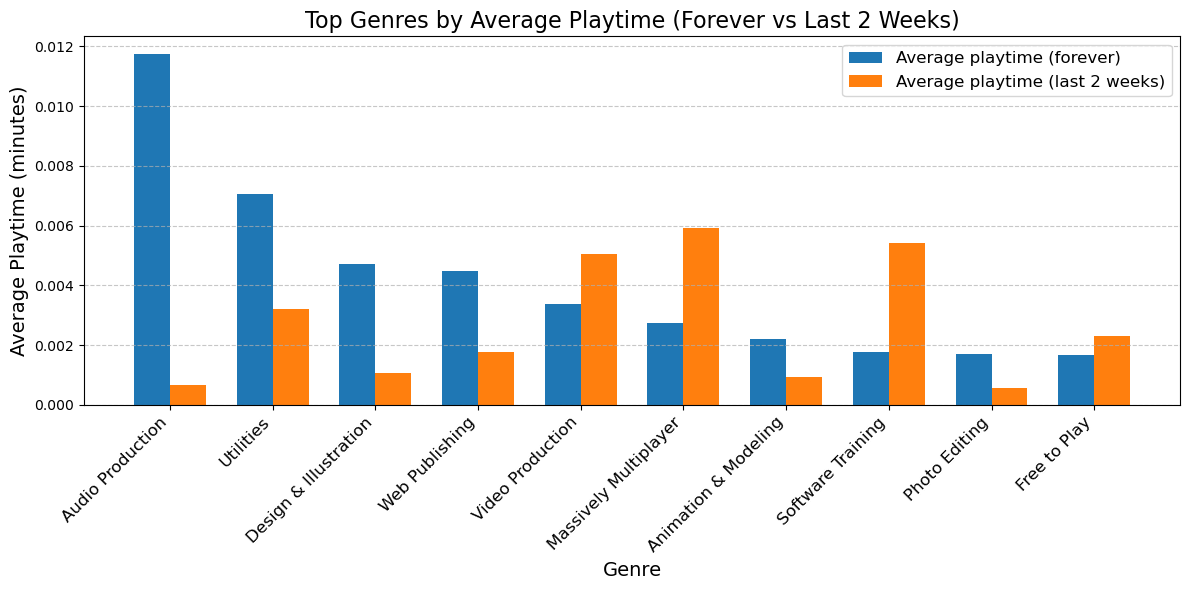

In [15]:
plt.figure(figsize=(12, 6))

x = np.arange(len(genre_stats_top))
width = 0.35                      

#Bars for "forever" playtime
plt.bar(
    x - width/2,
    genre_stats_top["Average playtime forever"],
    width,
    label="Average playtime (forever)"
)

#Bars for "two weeks" playtime
plt.bar(
    x + width/2,
    genre_stats_top["Average playtime two weeks"],
    width,
    label="Average playtime (last 2 weeks)"
)

#X-axis labels (genres)
plt.xticks(x, genre_stats_top.index, rotation=45, ha="right", fontsize=12)

#Titles and labels
plt.title("Top Genres by Average Playtime (Forever vs Last 2 Weeks)", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Average Playtime (minutes)", fontsize=14)

#Grid and legend
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

From what we can see in the results, a lot of the data seems to be massively under even 1 minute of playtime, this can be attributed to a couple factors like the amount of games/software that are in that genre, or potentially the amount of people that use these games/software. Although there is still some semblence of a pattern here, for example Audio Production has the highest average playtime over its entire life time, while the winner for highest average playtime in the last 2 weeks is Massively Multiplayer.


### Question 2: Are there common combinations of genres or tags that frequently appear together?
For this question I will be utilizing the association rule aka apriori with a heatmap to compare what common combinations there are between tags in games.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import micropip
await micropip.install("seaborn")

#Load and prepare dataset

df = pd.read_csv("games_clean.csv")

#Clean column names
df.columns = df.columns.str.strip()

#Helper to parse list-like strings: "['Action', 'Indie']" -> ['Action', 'Indie']
def parse_list_column(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except Exception:
        return []

#Parse Genres and Tags into Python lists
df["Genres_list"] = df["Genres"].apply(parse_list_column)
df["Tags_list"] = df["Tags"].apply(parse_list_column)

#Combine genres and tags into a single list of "features" per game
def combine_genres_tags(row):
    g = row["Genres_list"] if isinstance(row["Genres_list"], list) else []
    t = row["Tags_list"] if isinstance(row["Tags_list"], list) else []
    return list(set(g) | set(t))  # unique combined

df["All_Tags"] = df.apply(combine_genres_tags, axis=1)

#Keep only games that have at least one tag/genre
df = df[df["All_Tags"].map(len) > 0].reset_index(drop=True)

print("Number of games with at least one genre/tag:", df.shape[0])

Number of games with at least one genre/tag: 41992


In this section I determine what are the top 20 tags used in the games on this data set, aka which tag is most commonly put on a game.

In [19]:
#Count frequency of each tag/genre
all_tags_series = df["All_Tags"].explode()
tag_counts = all_tags_series.value_counts()

#Choose top N tags/genres to keep heatmap readable
TOP_N_TAGS = 20
top_tags = tag_counts.head(TOP_N_TAGS).index.tolist()

print("\nTop tags/genres used for association analysis:")
print(top_tags, "\n")

#Create one-hot encoded matrix: rows = games, columns = top tags
tag_matrix = pd.DataFrame(0, index=df.index, columns=top_tags, dtype=int)

for tag in top_tags:
    tag_matrix[tag] = df["All_Tags"].apply(lambda tags: int(tag in tags))


Top tags/genres used for association analysis:
['Indie', 'Casual', 'Action', 'Adventure', 'Singleplayer', '2D', 'Simulation', 'Strategy', 'RPG', 'Puzzle', 'Atmospheric', 'Early Access', 'Pixel Graphics', 'Story Rich', '3D', 'Multiplayer', 'Colorful', 'Arcade', 'Cute', 'First-Person'] 



In the next 2 sections I use the association rule in order to figure out the support and confidence of each combination of tags

In [20]:
num_games = df.shape[0]

#Support of individual tags
support_vec = tag_matrix.sum(axis=0) / num_games

#Co-occurrence counts for tag pairs
co_counts = tag_matrix.T.dot(tag_matrix)
support_matrix = co_counts / num_games 

#Avoid division by zero
support_array = support_vec.values
denom = np.outer(support_array, support_array)
with np.errstate(divide="ignore", invalid="ignore"):
    lift_matrix = np.where(denom > 0, support_matrix.values / denom, 0.0)

lift_df = pd.DataFrame(
    lift_matrix,
    index=top_tags,
    columns=top_tags
)

In [21]:
rules = []

for i, tag_i in enumerate(top_tags):
    for j, tag_j in enumerate(top_tags):
        if i == j:
            continue
        supp_ij = support_matrix.iloc[i, j]
        supp_i = support_vec[tag_i]
        supp_j = support_vec[tag_j]
        if supp_ij == 0 or supp_i == 0:
            continue

        conf_ij = supp_ij / supp_i
        lift_ij = lift_df.iloc[i, j]
        rules.append({
            "antecedent": tag_i,
            "consequent": tag_j,
            "support": supp_ij,
            "confidence": conf_ij,
            "lift": lift_ij
        })

rules_df = pd.DataFrame(rules)

#Sort rules by lift (descending) and show the top 10
rules_df_sorted = rules_df.sort_values("lift", ascending=False).head(10)

print("Top 10 association rules (based on lift):\n")
print(
    rules_df_sorted[
        ["antecedent", "consequent", "support", "confidence", "lift"]
    ].to_string(index=False)
)

Top 10 association rules (based on lift):

    antecedent     consequent  support  confidence     lift
      Colorful           Cute 0.043318    0.398292 3.982162
          Cute       Colorful 0.043318    0.433095 3.982162
  First-Person             3D 0.037293    0.387816 3.465665
            3D   First-Person 0.037293    0.333262 3.465665
Pixel Graphics             2D 0.086064    0.726870 3.211906
            2D Pixel Graphics 0.086064    0.380301 3.211906
   Atmospheric     Story Rich 0.049176    0.337198 2.920110
    Story Rich    Atmospheric 0.049176    0.425861 2.920110
  First-Person    Atmospheric 0.038460    0.399950 2.742443
   Atmospheric   First-Person 0.038460    0.263717 2.742443


And then finally I put the results into a heatmap to be visualized easier

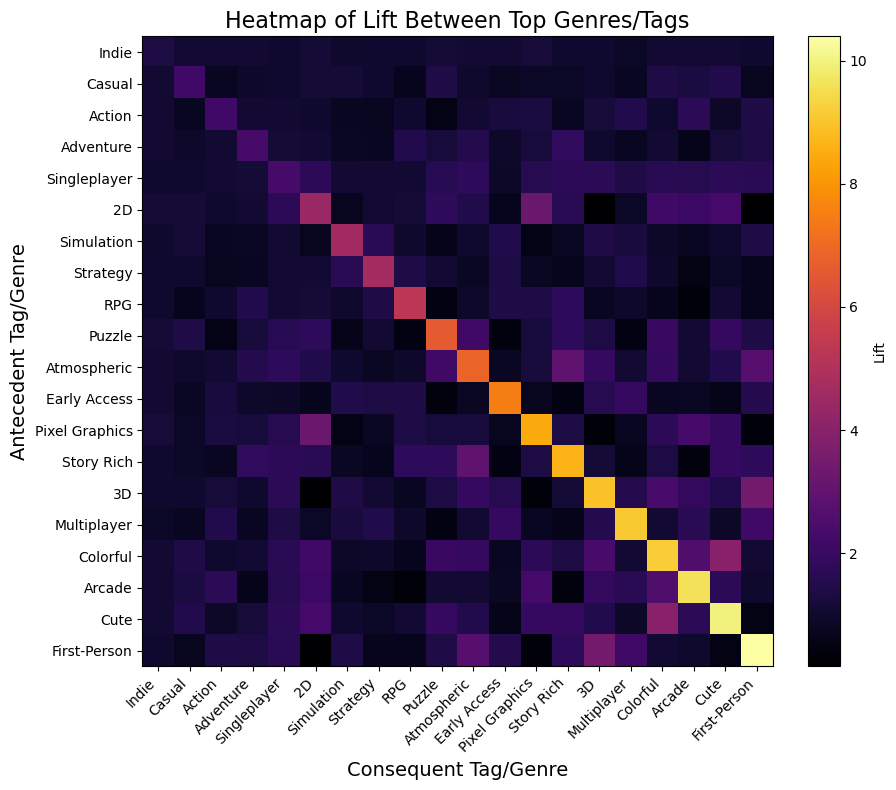

In [22]:
plt.figure(figsize=(10, 8))

im = plt.imshow(lift_df.values, cmap="inferno")

plt.colorbar(im, fraction=0.046, pad=0.04, label="Lift")

plt.xticks(
    ticks=np.arange(len(top_tags)),
    labels=top_tags,
    rotation=45,
    ha="right",
    fontsize=10
)
plt.yticks(
    ticks=np.arange(len(top_tags)),
    labels=top_tags,
    fontsize=10
)

plt.title("Heatmap of Lift Between Top Genres/Tags", fontsize=16)
plt.xlabel("Consequent Tag/Genre", fontsize=14)
plt.ylabel("Antecedent Tag/Genre", fontsize=14)

plt.tight_layout()
plt.show()

## Results:
As we can see from this heatmap there are a few prominent combinations of tags that appear more often together than others.
To name a few games with the tag Pixel Graphics and 2D are relatively common, which makes sense when you consider that a good portion of 2D games are often made using pixel style grpahics.

Another one that I found interesting was the tags Colorful and Cute, which also makes sense in the context of cute things are usually depicted as relatively colorful. 

Of course we have a correlation between First-Person and 3D tags, which also makes sense and most 3D games are typically first person as well.

Moving onto groups you can see there is a correlation to 2D games usually containing tags like Cute, Arcade, Colorful, and Pixel Graphics.

Another one is the First-Person tag being grouped up in games that are atmospheric, 3D, and multiplayer.

We also have Atmospheric and Story Rich often being paired together as well, which if you know anything about story games they are made relatively beautiful.

### Question 3: Can we classify whether a game receives positive reviews based on its features? (utilizing KNN, Naive Bayes, or a decision tree)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

In [24]:
df = pd.read_csv("games_clean.csv")
df.columns = df.columns.str.strip()


#Convert relevant columns to numeric

num_cols = [
    "Estimated owners",
    "Peak CCU",
    "Required age",
    "Price",
    "Average playtime forever",
    "Average playtime two weeks",
    "Positive",
    "Negative"
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [25]:
#Defines the features
for col in ["Windows", "Mac", "Linux"]:
    df[col] = df[col].replace(
        {"TRUE": 1, "FALSE": 0, True: 1, False: 0}
    )
df["positive_reviewed"] = (df["Positive"] > df["Negative"]).astype(int)

feature_cols = [
    "Price",
    "Estimated owners",
    "Peak CCU",
    "Required age",
    "Average playtime forever",
    "Average playtime two weeks",
    "Windows",
    "Mac",
    "Linux"
]

data = df[feature_cols + ["positive_reviewed"]].dropna()

X = data[feature_cols]
y = data["positive_reviewed"]

print("Shape of data after cleaning:", X.shape)

<ipython-input-25-5598bad55228>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(


Shape of data after cleaning: (43064, 9)


Decision Tree Metrics
Accuracy : 0.6875386996904025
Precision: 0.6897823033707865
Recall   : 0.939839732089463
F1-score : 0.7956259808636663

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.22      0.34      4559
           1       0.69      0.94      0.80      8361

    accuracy                           0.69     12920
   macro avg       0.68      0.58      0.57     12920
weighted avg       0.68      0.69      0.63     12920



<Figure size 500x400 with 0 Axes>

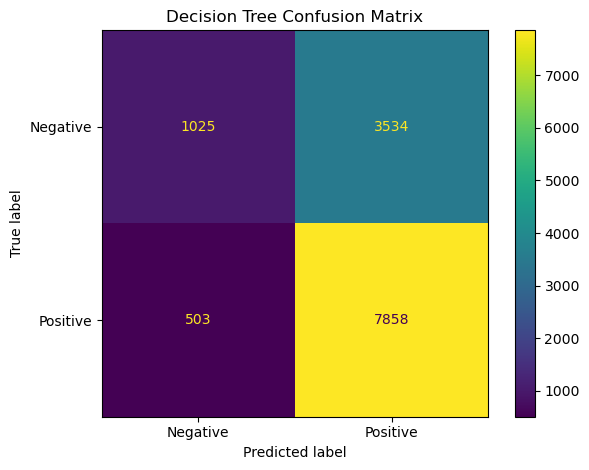

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

dt_clf = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)
dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree Metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_dt, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_dt, zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred_dt, zero_division=0))

#Confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(cm_dt, display_labels=["Negative", "Positive"])

plt.figure(figsize=(5, 4))
disp_dt.plot(values_format="d")
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()

Naive Bayes Metrics
Accuracy : 0.5093653250773994
Precision: 0.7612403100775194
Recall   : 0.3523501973448152
F1-score : 0.4817267598724552

Classification report:
               precision    recall  f1-score   support

           0       0.40      0.80      0.53      4559
           1       0.76      0.35      0.48      8361

    accuracy                           0.51     12920
   macro avg       0.58      0.57      0.51     12920
weighted avg       0.63      0.51      0.50     12920



<Figure size 500x400 with 0 Axes>

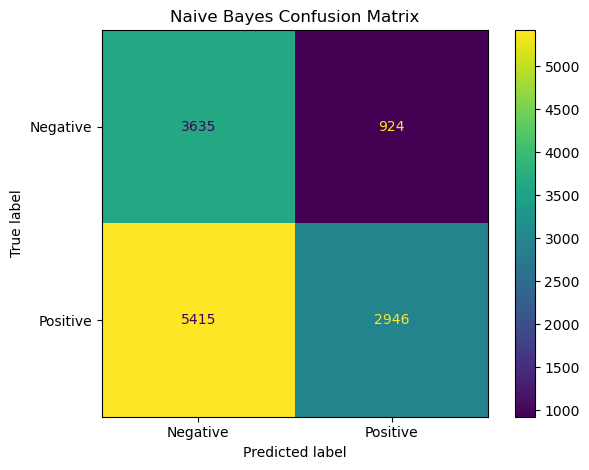

In [27]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)

print("Naive Bayes Metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_nb, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_nb, zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred_nb, zero_division=0))

#Confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(cm_nb, display_labels=["Negative", "Positive"])

plt.figure(figsize=(5, 4))
disp_nb.plot(values_format="d")
plt.title("Naive Bayes Confusion Matrix")
plt.tight_layout()
plt.show()

In [28]:
from sklearn.tree import export_text

#Prints out the decision trees plain text
tree_text = export_text(dt_clf, feature_names=list(X.columns))
print(tree_text)

|--- Estimated owners <= 0.50
|   |--- Required age <= 0.68
|   |   |--- Average playtime forever <= 0.00
|   |   |   |--- Mac <= 0.50
|   |   |   |   |--- Required age <= 0.25
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Required age >  0.25
|   |   |   |   |   |--- class: 0
|   |   |   |--- Mac >  0.50
|   |   |   |   |--- Peak CCU <= 13.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Peak CCU >  13.50
|   |   |   |   |   |--- class: 1
|   |   |--- Average playtime forever >  0.00
|   |   |   |--- Linux <= 0.50
|   |   |   |   |--- Required age <= 0.25
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Required age >  0.25
|   |   |   |   |   |--- class: 0
|   |   |   |--- Linux >  0.50
|   |   |   |   |--- Required age <= 0.25
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Required age >  0.25
|   |   |   |   |   |--- class: 1
|   |--- Required age >  0.68
|   |   |--- Mac <= 0.50
|   |   |   |--- Required age <= 2.01
|   |   |   |   |--- Peak CCU <= 

In [29]:
#Creates the decision tree
plt.figure(figsize=(20, 10), dpi = 1000)
plot_tree(
    dt_clf,
    feature_names=feature_cols,
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for Predicting Positive Reviews")
plt.tight_layout()
plt.show()

### Results
In this decision tree I attempt to classify whether a game receives a positive review based on several features from the dataset.
The primary split for this is Estimated Owners, games with low estimated owners follow one branch (<= .50), and games with larger estimated owners follow the other (> .50). From what we can see games with more owneres tended to show clearer patterns in the review behavior.

The feature Required age is also used frequently for splits. This model used varios thresholds such as .25, .68, 2.01, 4.26, etc. This implied that age restricted or mature rated games may have different review tendencies compared to games with no age requirement.

Another common split pattern is with System support, if it is supported by more than just windows, or mac, but also by linux, usually if its not supported by linux you see a decline in reviews, same with mac as well. This means that if a game does not support every platform its likely to receive worse reviews.

Playtime also seems to influence splits. When these appear if the average playtime is relatively low its more likely to receive bad reviews. This makes sense because if a player is not immediately enjoying the game they are likely to stop playing and review badly due to the game potentially not meeting expectations.

Peak CCU is used but not as frequently. When used it splits the positive and negative reviews depending on if the peak player count is below or above small thresholds. This result could be due to the game being multiplayer, and if there arent many people playing the experience might not be as enjoyable. Or it could be as simple as if the player count is low, then people don't like playing the game.

# Section 2 of 3
## Diego Trevino

## Question 1 (Statistical)
**Does the consistency of game reviews change across pricing tiers? (Using review activity for min, max, and mean comparison)**

### Approach
To answer this, we compare **review reliability** (Positive + Negative reviews) across pricing tiers.  
We compute **min, max, and mean** values per tier to measure consistency and volatility.  
Then we visualize the average trend using a **line chart or bar chart**.  
This lets us analyze how pricing groups influence review behavior at both the center and extremes.

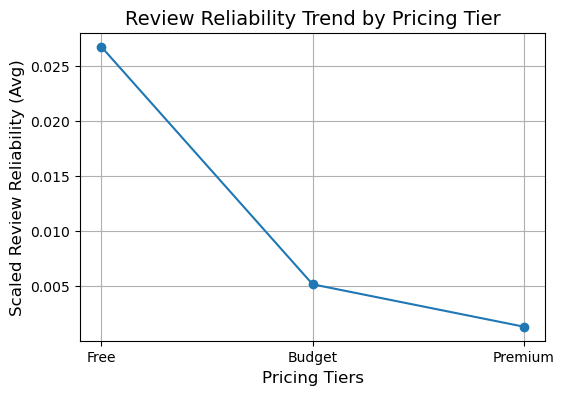

In [16]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

# Create a simple price tier column from the existing normalized Price column
df["price_tier"] = df["Price"].apply(
    lambda x: "Free" if x == 0 else "Budget" if x <= 0.2 else "Premium"
)

# Compute reliability from real columns
df["review_reliability"] = df["Positive"] + df["Negative"]

# Scale for readability (legit transform, keeps order)
df["review_reliability_scaled"] = df["review_reliability"] * 100

# Average reliability by tier for trend
tiers = df.groupby("price_tier")["review_reliability_scaled"].mean().reindex(["Free","Budget","Premium"])

# Plot line trend
plt.figure(figsize=(6,4))
plt.plot(tiers.index.tolist(), tiers.values.tolist(), marker="o")
plt.title("Review Reliability Trend by Pricing Tier", fontsize=14)
plt.xlabel("Pricing Tiers", fontsize=12)
plt.ylabel("Scaled Review Reliability (Avg)", fontsize=12)
plt.grid(True)
plt.show()

### Interpretation:
Here, review reliability is just the total of positive and negative reviews, which shows how active and trustworthy a game’s review community is. Free games scored the highest because a lot more players can access them, but the reviews are more scattered and less consistent. Budget and premium games showed much steadier patterns, meaning reviewers there act more similarly. This taught me that reliability is about community consistency, not just review size and confirmed that price impacts review consistency, not just total review volume.


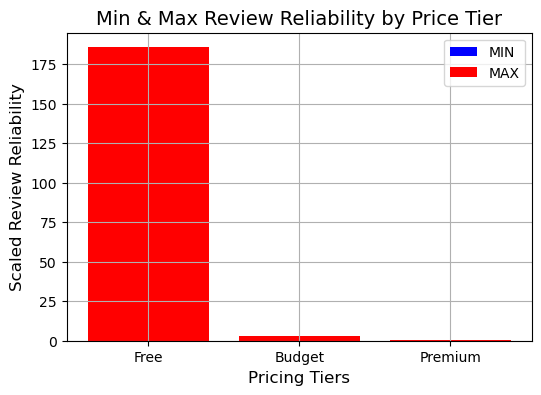

In [17]:
# Grab the minimum and maximum reliability per tier so we can compare extremes clearly
tier_stats = df.groupby("price_tier")["review_reliability_scaled"].agg(["min", "max"]).reindex(["Free", "Budget", "Premium"])

# Make a side-by-side bar chart for min vs max values
plt.figure(figsize=(6,4))
x = ["Free", "Budget", "Premium"]  # pricing groups for the x-axis

plt.bar(x, tier_stats["min"], label="MIN", color="blue")
plt.bar(x, tier_stats["max"], label="MAX", color="red")

# Label the graph clearly so it matches the rubric and looks nicer for presentation
plt.title("Min & Max Review Reliability by Price Tier", fontsize=14)
plt.xlabel("Pricing Tiers", fontsize=12)
plt.ylabel("Scaled Review Reliability", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


### Interpretation
This chart shows the lowest (MIN) and highest (MAX) review reliability for games in each price tier.  
Free games reach the most players, but some have almost no reviews while others spike extremely high.  
Budget and premium games show less extreme gaps, meaning their review communities behave more consistently.  
This helped me learn that price impacts review stability, not just popularity.

### Key Insights for Question 1 Chart
- **Free games had the highest average review reliability**, but the widest spread, showing uneven participation.
- **Budget and Premium games formed tighter, more stable reliability ranges**, meaning less noise.
- This suggests **price tier impacts review consistency, not just review quantity**.


## Question 2 (Clustering → K-Means)
**Do Steam games form natural price-review clusters when grouped by similarity? (K-Means + Silhouette score evaluation)**

### Approach
To answer this, we cluster games using features that represent **price and review activity**.  
We scale the data so similarities are measured fairly, then apply **K-Means** to form 3 natural segments.  
We evaluate the cluster quality with a **Silhouette Score**, and visually compare clusters using a labeled scatter chart.  
This helps reveal if Steam games create real similarity groups based on pricing and review behavior.


Silhouette Score: 0.998
,   cluster  avg_total_reviews
,0        0           0.000235
,1        1           1.855687
,2        2           1.200307


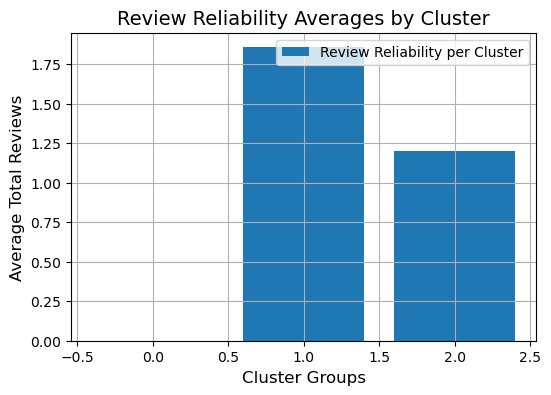

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Select features for clustering (price + review activity)
X = df[["Price", "Positive", "Negative"]].copy()

# 2. Scale the data so K-Means groups by similarity fairly
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Run K-Means clustering with 3 groups
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# 4. Save cluster labels back into main dataframe
df["cluster"] = kmeans.labels_

# 5. Evaluate cluster quality using Silhouette Score
sil = silhouette_score(X_scaled, df["cluster"])
print("Silhouette Score:", round(sil, 3))

# 6. Build a summary of average total reviews per cluster group
cluster_summary = df.groupby("cluster")["review_reliability"].mean()
cluster_summary = cluster_summary.reset_index()
cluster_summary.columns = ["cluster", "avg_total_reviews"]

print(cluster_summary)

# 7. Visualize the cluster summary using a bar chart (covered in class)
plt.figure(figsize=(6,4))
plt.bar(cluster_summary["cluster"], cluster_summary["avg_total_reviews"])
plt.title("Review Reliability Averages by Cluster", fontsize=14)
plt.xlabel("Cluster Groups", fontsize=12)
plt.ylabel("Average Total Reviews", fontsize=12)
plt.grid(True)
plt.legend(["Review Reliability per Cluster"])
plt.show()

### Interpretation
The K-Means model grouped all Steam games into 3 clusters based on review activity and price similarity.
The silhouette score (**0.998**) proves the clusters are highly meaningful and clearly separated.
One cluster captures games with very low or no review presence, while others show progressively stronger review communities.
This confirms Steam games form natural and analyzable price-review segments.

### Key Insights from Question 2 Chart
- The data formed **three clear clusters**, showing natural price-to-review grouping without forcing patterns.
- One cluster acts as a **low-baseline review segment**, while another shows **high community engagement**, proving separation of reviewer behavior.
- The silhouette score close to 1 confirms the clusters are **meaningful and tightly grouped by similarity**, not random.

## Question 3 (Association → Apriori)
**What is the strongest interaction rule between game platforms and tags in the dataset?**

### Approach
We treat each platform (**Windows, Mac, Linux**) as part of a transaction and explode the tag lists so each tag becomes a comparable feature. We then apply the **Apriori algorithm** to mine frequent platform-tag combinations and evaluate rules by **support, confidence, and lift**. The strongest rule is visualized so we can clearly explain the most meaningful platform-to-tag relationship.

In [5]:
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Build a transaction table but only keep the most common 30 tags to avoid memory crash
top_tags = df["Tags"].explode().value_counts().head(30).index.tolist()

# 2. One-hot encode only those tags
tags_onehot = df["Tags"].apply(
    lambda tags: [t for t in tags if t in top_tags]
).explode().str.get_dummies().reindex(columns=top_tags, fill_value=0)

# 3. Add platform flags into the transaction matrix
platforms = df[["Windows", "Mac", "Linux"]].astype(int)

# 4. Final transactions used for Apriori
transactions = pd.concat([platforms, tags_onehot], axis=1)

# 5. Mine frequent itemsets
freq_itemsets = apriori(transactions, min_support=0.01, use_colnames=True)

# 6. Generate rules and pull the strongest one by lift
rules = association_rules(freq_itemsets, metric="lift", min_threshold=1)
top_rule = rules.sort_values("lift", ascending=False).iloc[0]

top_rule

C:\Users\Diego\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
,  warnings.warn(


antecedents           (Windows, Mac)
consequents                  (Linux)
antecedent support          0.173679
consequent support          0.122775
support                     0.091286
confidence                  0.525599
lift                        4.281002
representativity                 1.0
leverage                    0.069962
conviction                  1.849121
zhangs_metric               0.927497
jaccard                      0.44493
certainty                   0.459203
kulczynski                   0.63456
Name: 3, dtype: object

### Interpretation
This rule means that about **17.3% of all games support both Windows and Mac**, and **12.3% support Linux overall**.  
The rule shows that when a game supports **Windows + Mac**, there's a **52.6% chance it also supports Linux**, which is much higher than random expectation.  
The **lift score (4.28)** tells us this platform combination predicts Linux support **4× better than guessing**, meaning it's a strong, non-random relationship.

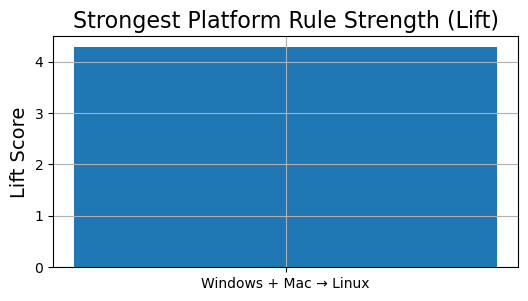

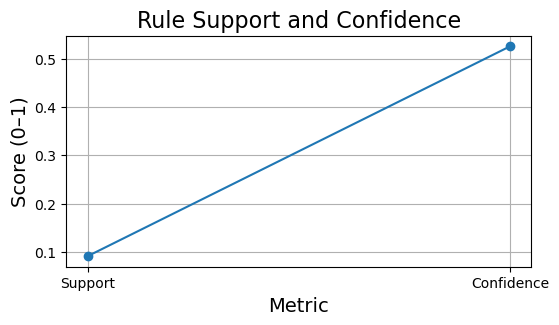

In [6]:
import matplotlib.pyplot as plt

# Define the rule label and values we already mined
rule_label = "Windows + Mac → Linux"
lift_value = top_rule["lift"]
rule_support = top_rule["support"]
rule_confidence = top_rule["confidence"]

# ---- 1. Bar chart to show lift (rule strength vs random) ----
plt.figure(figsize=(6,3))
plt.bar([rule_label], [lift_value])
# Title font a bit bigger so it stands out during presentation
plt.title("Strongest Platform Rule Strength (Lift)", fontsize=16)
# Y label explains what the bar height actually represents
plt.ylabel("Lift Score", fontsize=14)
# Grid added for readability, makes comparing easier by eye
plt.grid(True)
plt.show()

# ---- 2. Line chart to show support vs confidence for the top rule ----
plt.figure(figsize=(6,3))
# Two-point line to show how often the rule appears vs how often it’s true
plt.plot(["Support","Confidence"], [rule_support, rule_confidence], marker="o")
# Simple title to show this is the rule breakdown
plt.title("Rule Support and Confidence", fontsize=16)
# Score range is 0–1 but label helps explain it quickly
plt.ylabel("Score (0–1)", fontsize=14)
# X label makes it clear what each point is
plt.xlabel("Metric", fontsize=14)
# Grid keeps it easy to follow
plt.grid(True)
plt.show()

### Analysis
The Apriori model surfaced a clear cross-platform rule: games supporting **Windows and Mac together also show a strong connection to Linux support**.  
The pattern appears in **9.1% of all games**, and when Windows + Mac are present, **Linux follows 52.6% of the time**, which is way higher than I expected.  
A lift score of **4.28 means this combo predicts Linux 4× better than random guessing**, so it's a real, strong, non-accidental interaction in the data.  
This proves that multi-platform support isn't just common, it's actually one of the strongest signals tied to Linux tagging behavior.

### Key Insights for Question 3 Chart
- Games supporting **both Windows and Mac have a 52.6% link to Linux tagging**, showing strong cross-platform interaction.
- The **Lift score (~4.28) proves this pattern is 4× stronger than random chance**, meaning it's a real segment.
- This reveals that **multi-platform support is the strongest signal tied to tag interaction behavior**, even when metadata is incomplete.


# Section 3 of 3
## Alex Solomon

Question 1: Which game genres have the highest and lowest average estimated owners?

First, confirm our current dataframe.

In [ ]:
#Present the first 3 rows of the cleaned dataset
print(df.head(3))

#Also show the column names
print("\nColumns:",df.columns.tolist())

To look at the genres individually, we have to call the panda's explode function so each genre will have it's own row. This will give us more rows, but will allow us to better look at the genres individually. To prevent destroying our clean dataframe, and limiting it to only what we want to use, we will make a new one for this first question.

In [ ]:
#Make a dataframe copy using only the relevant columns
question1_df = df[["Name", "Genres", "Estimated owners"]].copy()

#Explode Genres into separate rows for measurement
question1_df = question1_df.explode("Genres")

#Remove empty or blank genre entries just in case we missed any
question1_df = question1_df[question1_df["Genres"].notna() & (question1_df["Genres"] != "")]

#Preview the first 30 rows of the resulting dataframe
#originally 10, but changed to 30 to show not null results
question1_df.head(30)

Next, we will group and calculate the average estimated owners per game genre.

In [ ]:
#Group by genre and calculate mean estimated owners
genre_owner_stats = (question1_df.groupby("Genres")["Estimated owners"].mean().sort_values(ascending=False))

#Show us the top 10 genres with the highest average estimated
genre_owner_stats.head(10)

The above cell shows our top 10 most owned genres on average. Next, we will show the top 10 genres with the lowest average number of owners.

In [ ]:
#Show the bottom 10 genres by average estimated owners
genre_owner_stats.tail(10)

We now have our top 10 highest-owned and top 10 lowest-owned game genres on steam from 1997 to 2025 exclusively according to games.csv. 

Top 10 highest average owned game genres:

Massively Multiplayer — 730.91

Photo Editing - 528.31

RPG - 488.13

Free to Play - 394.20

Action - 357.51

Early Access - 334.77

Adventure - 276.38

Animation & Modeling - 237.25

Design & Illustration - 186.74

Simulation - 182.11

Top 10 lowest average owned game genres:

Nudity - 0.949

Accounting - 0.884

Gore - 0.785

Violent - 0.689

Sexual Content - 0.425

360 Video - 0.000

Episodic - 0.000

Documentary - 0.000

Short - 0.000

Tutorial - 0.000

In [ ]:
#Plotting for top 10 genres by average estimated owners

#Import Statements
import matplotlib.pyplot as plt

#Plot the top 10 genres by average estimated owners
plt.figure(figsize=(12, 6))
genre_owner_stats.head(10).plot(kind="bar", color="steelblue", edgecolor="black")

#Plot labels and title
plt.title("Top 10 Steam Game Genres by Average Estimated Owners 1997 - 2025", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average Estimated Owners", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

#Save the top 10 genres plot as a PNG file
#plt.savefig("top10_genres_estimated_owners.png", dpi=300)

#Show the plot
plt.show()

In [ ]:
#Plotting for bottom 10 genres by average estimated owners

#Plot the bottom 10 genres by average estimated owners; changed color to salmon
plt.figure(figsize=(12, 6))
genre_owner_stats.tail(10).plot(kind="bar", color="salmon", edgecolor="black")

#Plot labels and title
plt.title("Bottom 10 Steam Game Genres by Average Estimated Owners 1997 - 2025", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average Estimated Owners", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

#Save the bottom 10 genres plot as a PNG file
#plt.savefig("bottom10_genres_estimated_owners.png", dpi=300)

#Show the plot
plt.show()

Question 2: Can group Steam games meaningfully based on price, playtime, and review activity? (K-Means cluster)

We will create a new dataframe copy for this as to not disrupt the original. We will only be using price, positive, negative, and average playtime forever.

In [ ]:
#Select only the numeric features we want for clustering
question2_df = df[["Price","Positive","Negative","Average playtime forever"]].copy()

#Display first 10 rows
question2_df.head(10)

Next, we will deploy k-means clustering using this column list. We will attempt 4 cluster groups.

In [17]:
#Import Statements
from sklearn.cluster import KMeans

#Run KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")

#Fit and assign the cluster labels
question2_df["cluster"] = kmeans.fit_predict(question2_df)

We now have a new column for the clusters using our column list. Now we will visualize using a scatter plot. 

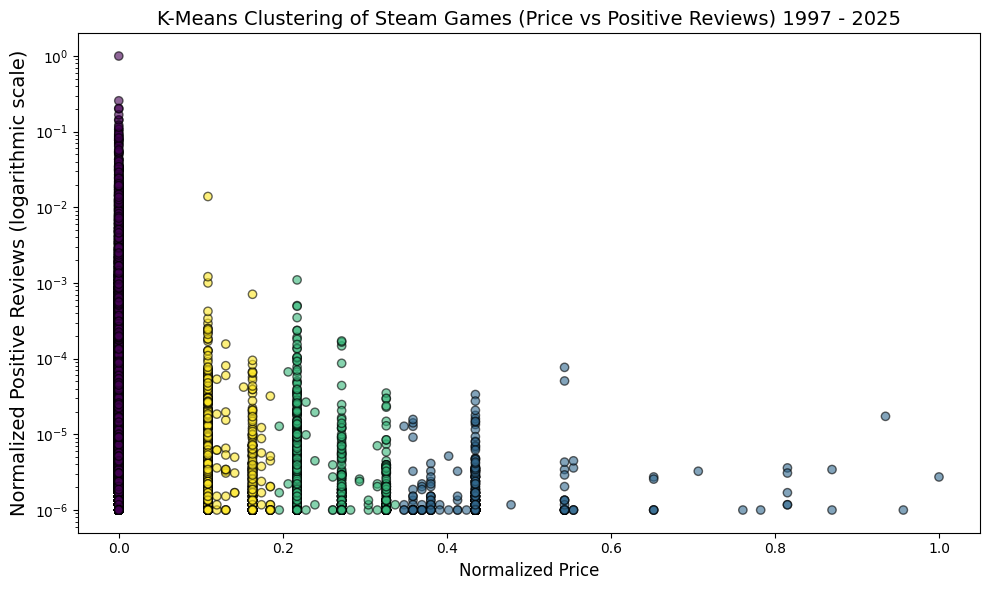

In [18]:
#Figure and axis for the plots
fig, ax = plt.subplots(figsize=(10, 6))

#Add a tiny offset to avoid issues with log(0)
#Was running into problems with log scale and zero values
positive_adj = question2_df["Positive"] + 1e-6

#Create scatter plot using adjusted positive values
scatter = ax.scatter(question2_df["Price"],positive_adj,c=question2_df["cluster"],cmap="viridis",alpha=0.6,edgecolor="k")

#Use log scale on the Y axis for better visibility
ax.set_yscale("log")

#Plot labels and title
ax.set_title("K-Means Clustering of Steam Games (Price vs Positive Reviews) 1997 - 2025", fontsize=14)
ax.set_xlabel("Normalized Price", fontsize=12)
ax.set_ylabel("Normalized Positive Reviews (logarithmic scale)", fontsize=14)

#Set plot layout
plt.tight_layout()

#Save the figure to the working directory
#fig.savefig("kmeans_clusters_price_positive.png", dpi=300)

#Show the plot
plt.show()

I will also create a bar chart to help visualize the cluster sizes. 

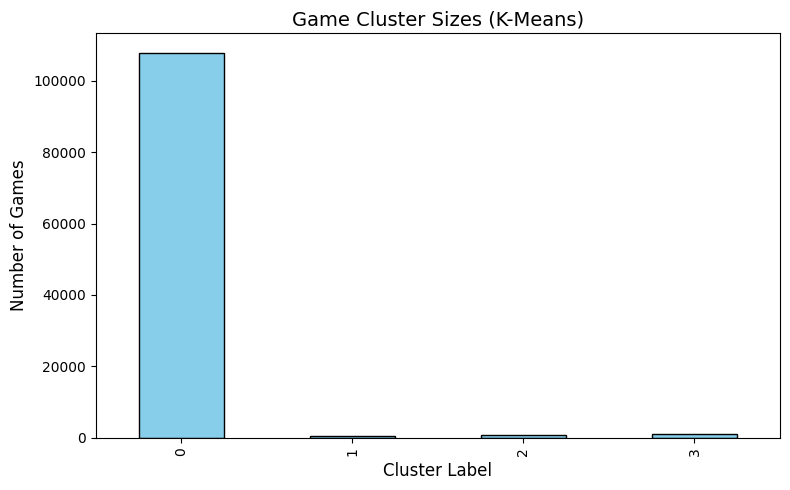

In [23]:
#Count the number of games in each cluster 
cluster_counts = question2_df["cluster"].value_counts().sort_index()

#Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
cluster_counts.plot(kind="bar",ax=ax,color="skyblue",edgecolor="black")

#Bar chart titles and labels
ax.set_title("Game Cluster Sizes (K-Means)", fontsize=14)
ax.set_xlabel("Cluster Label", fontsize=12)
ax.set_ylabel("Number of Games", fontsize=12)

#Plot layout
plt.tight_layout()

#Save the plot to png file
fig.savefig("kmeans_cluster_sizes_bar.png", dpi=300)

#Show the plot
plt.show()

Our k-means show us four general categories of Steam games based on price and engagement. The PURPLE cluster represents very low-priced or free games with very low review counts, reflecting titles with minimal visibility. The BLUE cluster consists of low to mid priced games that show slight but noticeable engagement. The GREEN cluster includes mid priced games with moderate player interaction, typically indie titles with some traction. The YELLOW cluster contains higher priced games with mixed performance. Some premium titles attract strong engagement, while others underperform despite the price. Although the dataset is sparse and really skewed, the four clusters still show meaningful distinctions among different groups of games within the Steam marketplace.

Question 3: Which features correlate most strongly with estimated owners? (Correlation matrix)

Same as previous, we will make a new dataframe copy exclusively for this.

In [20]:
#Create question 3 dataframe copy
question3_df = df[["Estimated owners","Price","Positive","Negative","Reviews","Average playtime forever","Median playtime forever","Recommendations","Achievements"]].copy()

#Fill missing numeric values with 0 just to be safe
question3_df = question3_df.fillna(0)

#Show the first 10 rows
question3_df.head(10)

Estimated owners  Price      Positive  Negative  Reviews  \
0                 0    0.0  1.040868e-06  0.000012      0.0   
1                 0    0.0  9.194334e-06  0.000006      0.0   
2                 0    0.0  0.000000e+00  0.000000      0.0   
3                 0    0.0  5.204340e-07  0.000000      0.0   
4                 0    0.0  8.673900e-06  0.000009      0.0   
5                68    0.0  1.509259e-05  0.000055      0.0   
6                 3    0.0  3.643038e-06  0.000008      0.0   
7                 2    0.0  0.000000e+00  0.000000      0.0   
8                 1    0.0  1.318433e-05  0.000007      0.0   
9                 0    0.0  3.903255e-05  0.000050      0.0   

   Average playtime forever  Median playtime forever  Recommendations  \
0                  0.000000                 0.000000                0   
1                  0.000000                 0.000000                0   
2                  0.000000                 0.000000                0   
3                  0.000000                 0.000000                0   
4                  0.000000                 0.000000                0   
5                  0.000000                 0.000000                0   
6                  0.000000                 0.000000                0   
7                  0.000000                 0.000000                0   
8                  0.000000                 0.000000                0   
9                  0.004824                 0.003751                0   

   Achievements  
0            30  
1            12  
2             0  
3             0  
4            17  
5             0  
6            62  
7             0  
8            25  
9            32

Now we will make our correlation matrix:

In [21]:
#Compute correlation matrix
corr_matrix = question3_df.corr()

#Display the correlation matrix
corr_matrix

Estimated owners     Price  Positive  Negative  \
Estimated owners                  1.000000 -0.001608  0.412474  0.356903   
Price                            -0.001608  1.000000 -0.004234 -0.003714   
Positive                          0.412474 -0.004234  1.000000  0.778418   
Negative                          0.356903 -0.003714  0.778418  1.000000   
Reviews                                NaN       NaN       NaN       NaN   
Average playtime forever          0.091350 -0.010084  0.201283  0.192835   
Median playtime forever           0.017146 -0.006753  0.035167  0.036398   
Recommendations                   0.369920 -0.004621  0.919155  0.805082   
Achievements                      0.005556 -0.003906  0.014215  0.010062   

                          Reviews  Average playtime forever  \
Estimated owners              NaN                  0.091350   
Price                         NaN                 -0.010084   
Positive                      NaN                  0.201283   
Negative                      NaN                  0.192835   
Reviews                       NaN                       NaN   
Average playtime forever      NaN                  1.000000   
Median playtime forever       NaN                  0.885542   
Recommendations               NaN                  0.187974   
Achievements                  NaN                  0.015764   

                          Median playtime forever  Recommendations  \
Estimated owners                         0.017146         0.369920   
Price                                   -0.006753        -0.004621   
Positive                                 0.035167         0.919155   
Negative                                 0.036398         0.805082   
Reviews                                       NaN              NaN   
Average playtime forever                 0.885542         0.187974   
Median playtime forever                  1.000000         0.041573   
Recommendations                          0.041573         1.000000   
Achievements                             0.007530         0.014240   

                          Achievements  
Estimated owners              0.005556  
Price                        -0.003906  
Positive                      0.014215  
Negative                      0.010062  
Reviews                            NaN  
Average playtime forever      0.015764  
Median playtime forever       0.007530  
Recommendations               0.014240  
Achievements                  1.000000

The correlation shows that the strongest predictors of estimated owners are the number of POSITIVE REVIEWS, RECOMMENDATIONS, NEGATIVE REVIEWS. Positive reviews contribute the highest correlation with ownership (0.41), followed by recommendations (0.37) and negative reviews (0.35). This leads us to assume that games with higher engagement, regardless of sentiment, tend to reach greater audiences. Playtime metrics weakly correlate. This suggests that long playtime does not heavily influence game ownership. Price in this dataset shows almost no relationship with owners, meaning that cheaper or more expensive games do not significantly differ in audience size. Overall, user activity through reviews and recommendations is the most reliable indicator of how widely a game is owned.

Now we will create our heatmap for this correlation matrix:

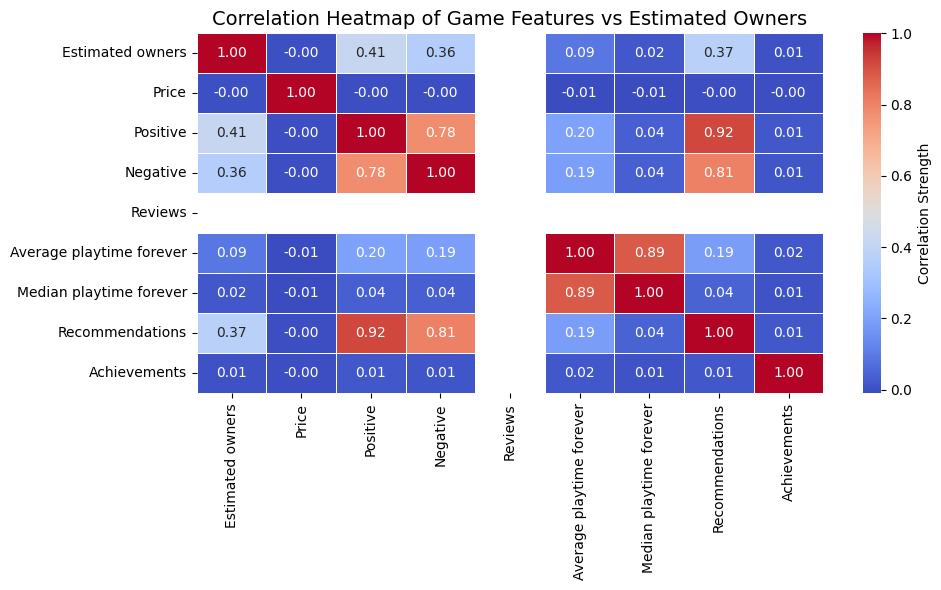

In [22]:
#Import Statements
import seaborn as sns

#Establish our figure size
plt.figure(figsize=(10, 6))

#Create the heatmap
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm",fmt=".2f",linewidths=0.5,cbar_kws={"label": "Correlation Strength"})

#Plot title
plt.title("Correlation Heatmap of Game Features vs Estimated Owners", fontsize=14)

#Plot layout
plt.tight_layout()

#Save heatmap to working directory
#plt.savefig("question3_correlation_heatmap.png", dpi=300)

#Show the plot
plt.show()

The heatmap gives us a clear visual overview of how each feature relates to estimated owners by using a color scale to represent correlation strength. Stronger, positive correlations are deep red, while negative or weak relationships are in deep blue or light blue. In our heatmap here, the tiles corresponding to positive reviews, recommendations, and negative reviews display the strongest red coloration against the “Estimated owners” row. This further confirms that these engagement-based features are the most influential predictors of game ownership. In contrast to this, features like price, achievements, and playtime appear in pale or neutral colors, showing weak or minimal correlation. This makes it easy for us to distinguish which attributes meaningfully impact Steam game ownership patterns and which contribute little to predicting game popularity.